In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torchvision.transforms import functional as TF

import pietorch

# Poisson image editing examples
## Image (2D)

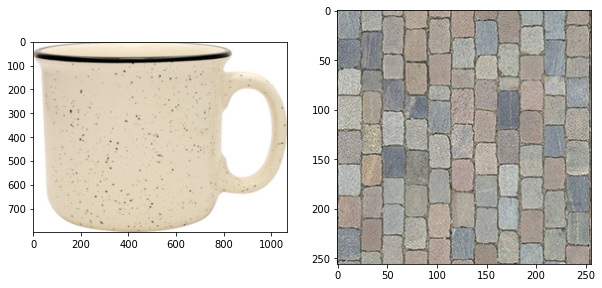

In [2]:
img_1_png = Image.open('example_images/mug.png')
img_1 = Image.new("RGB", img_1_png.size, (255, 255, 255))
img_1.paste(img_1_png, mask=img_1_png.getchannel('A'))

img_2 = Image.open('example_images/brick_texture.jpg')

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

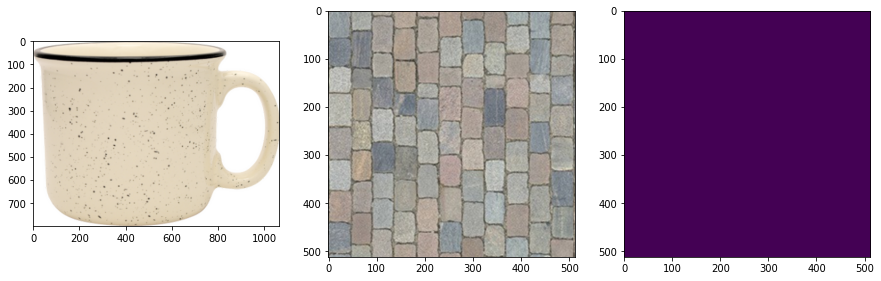

In [3]:
target = TF.to_tensor(img_1)

source = TF.resize(TF.to_tensor(img_2), [512, 512])

corner_coord = torch.tensor([144, 100])

mask = torch.ones(source.shape[1:])

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(torch.movedim(target, 0, -1))
ax[1].imshow(torch.movedim(source, 0, -1))
ax[2].imshow(mask)

Took  0.029787302017211914


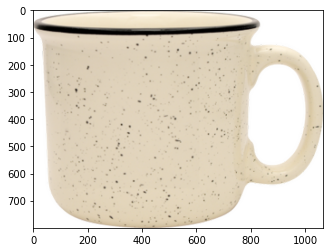

In [4]:
start = time()
res = pietorch.blend(target, source, torch.zeros(source.shape[1:]), corner_coord, True, channels_dim=0)
print('Took ', time() - start)

plt.imshow(torch.movedim(res, 0, -1))

tensor(0.) - tensor(0.0024) / tensor(0.) - tensor(0.0365)


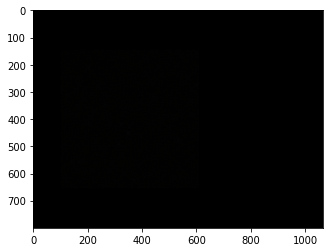

In [5]:
recon_diff = torch.abs(res - target)

print(torch.min(recon_diff), '-', torch.mean(recon_diff), '/', torch.median(recon_diff), '-', torch.max(recon_diff))

plt.imshow(torch.movedim(recon_diff, 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Took  0.026986360549926758


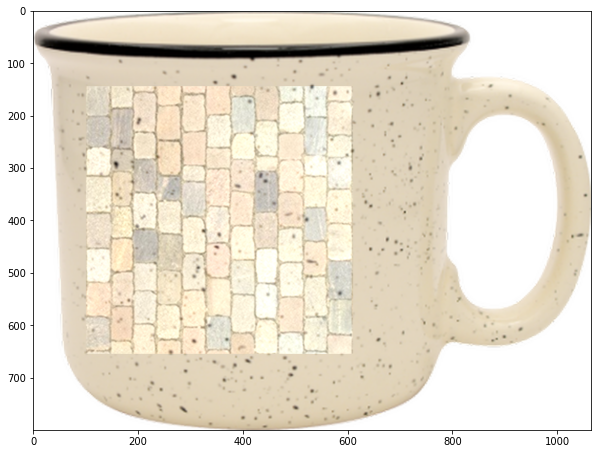

In [6]:
start = time()
res = pietorch.blend(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(torch.movedim(res, 0, -1))

tensor(0.3477)


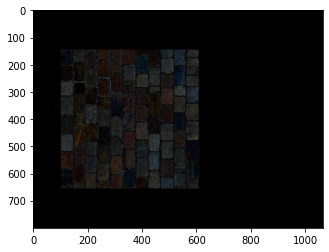

In [7]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Took  0.15250134468078613


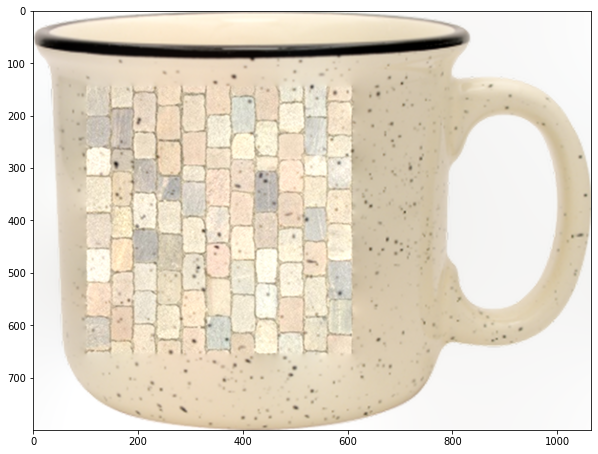

In [8]:
start = time()
res = pietorch.blend_wide(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)

plt.figure(figsize=(10, 8))
plt.imshow(torch.movedim(res, 0, -1))

tensor(0.3705)


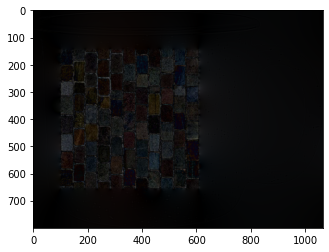

In [12]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))

### Example of using cache

In [ ]:
from pietorch import CachedPoissonBlender

# Add green function to cache ahead of time
cached_blender = CachedPoissonBlender([(source.shape, 0)])

start = time()
res = cached_blender.blend(target, source, mask, corner_coord, True, channels_dim=0)
print('Took ', time() - start)


### 2D OpenCV comparison

Took  0.05967354774475098


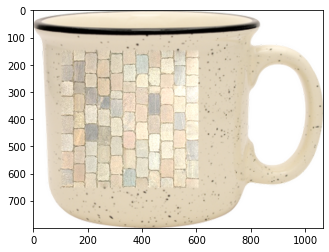

In [9]:
import cv2

cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, [512, 512]))
cv_mask = mask.numpy().astype(np.uint8) * 255
cv_centre_coord = (corner_coord.numpy() + np.array(cv_mask.shape) // 2)

start = time()
cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           tuple(cv_centre_coord[::-1]),
                           cv2.NORMAL_CLONE)
print('Took ', time() - start)

plt.imshow(cv_res)

212


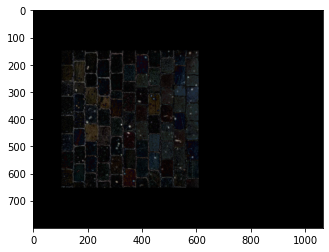

In [10]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

Took  0.0625753402709961


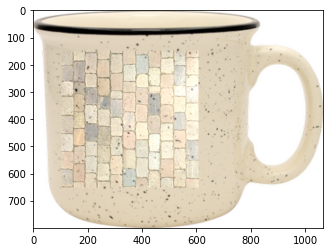

In [11]:
start = time()
cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           tuple(cv_centre_coord[::-1]),
                           cv2.MIXED_CLONE)
print('Took ', time() - start)

plt.imshow(cv_res)

111


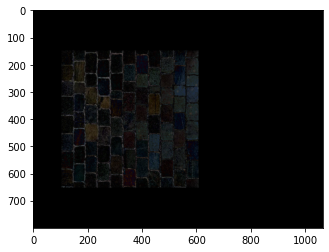

In [12]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

### Numpy interface example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Took  0.1122283935546875


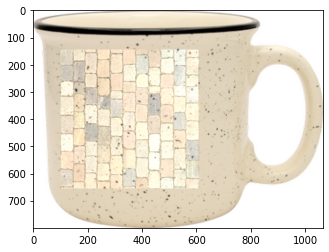

In [26]:
# Apply to OpenCV data, as is already np.ndarray's

np_target = cv_img_1.astype(float)
np_source = cv_img_2.astype(float)
np_mask = mask.numpy()
np_corner_coord = corner_coord.numpy()

start = time()
np_res = pietorch.blend_numpy(np_target, np_source, np_mask, np_corner_coord, True, channels_dim=2)
print('Took ', time() - start)

plt.imshow(np_res / 255)

68.0230925141891


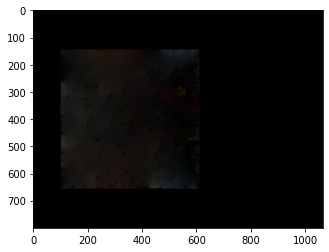

In [25]:
np_diff = np.abs(np_res - cv_res)
print(np.max(np_diff))

plt.imshow(np_diff / 255)

## Poisson image editing over time and space

In [ ]:
import imageio

def read_gif(file_path):
    return torch.stack([TF.to_tensor(im) for im in imageio.get_reader(file_path)])

wave = read_gif('example_images/wave.gif')[:, :3]
splat = read_gif('example_images/splat.gif')[:, :3]

In [ ]:
plt.imshow(torch.movedim(wave[0], 0, -1))

In [ ]:
target_gif = wave

source_gif = TF.resize(torch.cat([splat, torch.flip(splat, [0])]), [300, 300])

corner_coord = torch.tensor([4, 100, 100])

mask_gif = torch.ones((source_gif.shape[0], *source_gif.shape[2:]))

In [ ]:
start = time()
res_gif = pietorch.blend(target_gif, source_gif, mask_gif, corner_coord, True, channels_dim=1)
print('Took ', time() - start)

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

gif = res_gif

anim_fig, anim_ax = plt.subplots()
anim_ax.set_axis_off()
img_ax = plt.imshow(torch.movedim(gif[0], 0, -1))

def animate_gif(frame_num):
    img_ax.set_data(torch.movedim(gif[frame_num], 0, -1))
    return img_ax

anim =  FuncAnimation(anim_fig, animate_gif, frames=len(gif), interval=15)
plt.show()

In [ ]:
anim.save('example_images/blended.gif', fps=30)

### Slice-wise OpenCV comparison

In [ ]:
def read_gif_numpy(file_path: str) -> np.ndarray:
    return np.stack([im for im in imageio.get_reader(file_path)])

cv_wave = read_gif_numpy('example_images/wave.gif')[..., :3]
cv_splat = read_gif_numpy('example_images/splat.gif')[..., :3]

In [ ]:
plt.imshow(cv_wave[0])

In [ ]:
import cv2

cv_target_gif = cv_wave

cv_source_gif = np.stack([cv2.resize(im, (300, 300)) for im in np.concatenate([cv_splat, np.flip(cv_splat, 0)])])

cv_gif_first_frame = 4
cv_gif_centre_coord = (250, 250)

cv_mask_gif = np.ones((300, 300), dtype=np.uint8) * 255

In [ ]:
cv_res_gif = cv_target_gif.copy()
start = time()
for source_frame in range(len(cv_source_gif)):
    target_frame = cv_gif_first_frame + source_frame
    cv_res_gif[target_frame] = cv2.seamlessClone(cv_source_gif[source_frame],
                                                 cv_target_gif[target_frame],
                                                 cv_mask_gif,
                                                 cv_gif_centre_coord,
                                                 cv2.MIXED_CLONE)
print('Took ', time() - start)

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

gif = cv_res_gif

anim_fig, anim_ax = plt.subplots()
anim_ax.set_axis_off()
img_ax = plt.imshow(gif[0])

def animate_gif(frame_num):
    img_ax.set_data(gif[frame_num])
    return img_ax

anim =  FuncAnimation(anim_fig, animate_gif, frames=len(gif), interval=15)
plt.show()

In [ ]:
anim.save('example_images/cv_blended.gif', fps=30)

## 3D Poisson image editing

In [ ]:
import SimpleITK as sitk

sitk_brain = sitk.ReadImage('example_images/brain.nii.gz')
brain = sitk.GetArrayFromImage(sitk_brain)

brain.shape

In [ ]:
plt.imshow(brain[100], cmap='gray')

In [ ]:
target_3d = torch.from_numpy(brain)

source_3d = torch.zeros((100, 100, 100), dtype=torch.float64)
mask_3d = torch.zeros_like(source_3d, dtype=torch.float64)
radii = centre = np.array(source_3d.shape) // 2

corner_3d = torch.tensor([78, 78, 78])

for i in range(-radii[0], radii[0]):
    for j in range(-radii[1], radii[1]):
        for k in range(-radii[2], radii[2]):
            distance = np.sqrt(i ** 2 + j ** 2 + k ** 2)
            if distance <= 50:
                coord = tuple(np.array([i, j, k]) + centre)
                source_3d[coord] = np.sin(distance * np.pi / 5) / 4
                mask_3d[coord] = 1

In [ ]:
plt.imshow(source_3d[70], cmap='gray')

In [ ]:
start = time()
res_3d = pietorch.blend(target_3d, source_3d, mask_3d, corner_3d, True)
print('Took ', time() - start)

In [ ]:
plt.imshow(res_3d[100], cmap='gray')

In [ ]:
res_3d_sitk = sitk.GetImageFromArray(res_3d.numpy())

res_3d_sitk.CopyInformation(sitk_brain)

res_3d_sitk.GetSpacing()

In [ ]:
sitk.WriteImage(res_3d_sitk, 'example_images/blended_brain.nii.gz')
